In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
####
from os import listdir
from os.path import isfile, join
import numpy
import glob
import random
from tensorflow.python.keras import layers

from PIL import Image
from scipy import ndimage

Using TensorFlow backend.


In [2]:
#'C:/Users/rdokh/Downloads/car-synapse/data/train'
#'C:/Users/rdokh/Downloads/car-synapse/data/train_masks_main'
#DATA_PATH = 'C:/Users/rdokh/Downloads/car-synapse/data'
IMAGE_LIB = "C:/Users/rdokh/data/x"
MASK_LIB = "C:/Users/rdokh/data/y"


In [3]:

IMG_HEIGHT, IMG_WIDTH = 48, 48
SEED=1

mypath=IMAGE_LIB
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]

x_data = numpy.empty((len(onlyfiles), IMG_HEIGHT, IMG_WIDTH,3), dtype='float32')
for n in range(0, len(onlyfiles)):
  img = cv2.imread( join(mypath,onlyfiles[n]) ).astype("int16").astype('float32')
  img = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)#reshape data
  x_data[n] = (img - np.min(img)) / (np.max(img) - np.min(img))#normalize data
  

In [4]:
mypath=MASK_LIB
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
y_data = numpy.empty((len(onlyfiles), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for n in range(0, len(onlyfiles)):
  img = ndimage.imread( join(mypath,onlyfiles[n]) , flatten=True).astype('float32')
  img = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
  y_data[n] = (img - np.min(img)) / (np.max(img) - np.min(img))
y_data = y_data[:,:,:,np.newaxis]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """


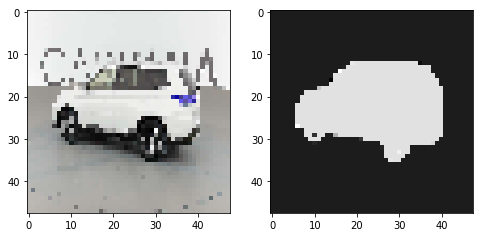

In [5]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
n_rand=random.randint(0,len(onlyfiles)-1)
ax[0].imshow(x_data[n_rand,:,:,:])
ax[1].imshow(y_data[n_rand,:,:,0], cmap='gray')
plt.show()


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.25)


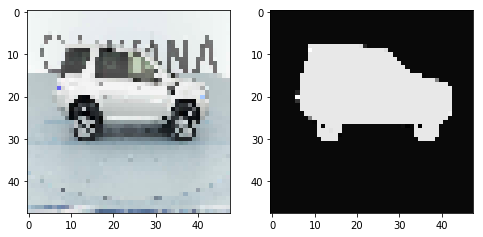

In [7]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
n_rand=random.randint(0,len(x_train)-1)
ax[0].imshow(x_train[n_rand,:,:,:])
ax[1].imshow(y_train[n_rand,:,:,0], cmap='gray')
plt.show()

In [125]:
from tensorflow.python.keras import layers
input_layer = Input(shape=x_train[1].shape)
#inputs = layers.Input(shape=x_train.shape)
c1 = Conv2D(filters=24, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=48, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=96, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=96, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=48, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=36, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=72, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [126]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 48, 48, 24)   672         input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_43 (MaxPooling2D) (None, 24, 24, 24)   0           conv2d_124[0][0]                 
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 24, 24, 48)   10416       max_pooling2d_43[0][0]           
__________________________________________________________________________________________________
max_poolin

In [127]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [128]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

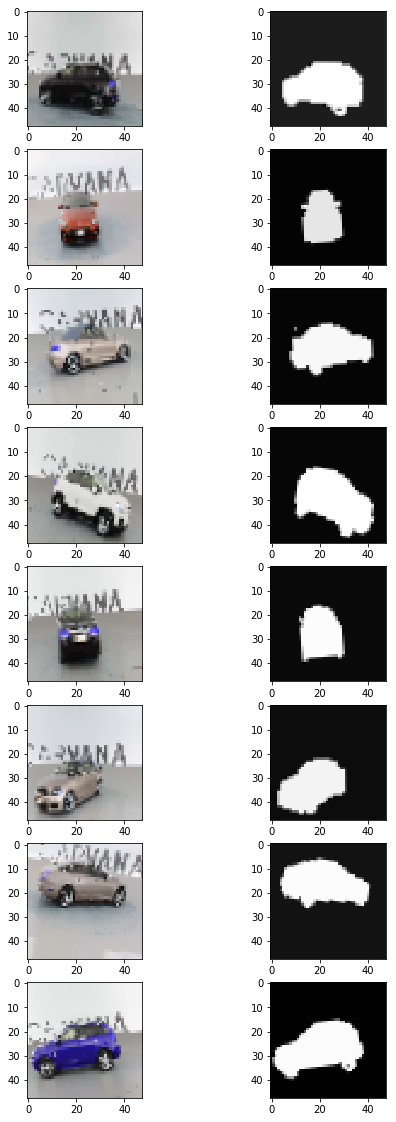

In [129]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,:])
    ax[i,1].imshow(mask_batch[i,:,:,0],'gray')
plt.show()

In [130]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [131]:
weight_saver = ModelCheckpoint('cars.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [132]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 210,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
 - 49s - loss: 0.4062 - dice_coef: 0.5256 - val_loss: 0.3609 - val_dice_coef: 0.6349
Epoch 2/10
 - 45s - loss: 0.3483 - dice_coef: 0.6152 - val_loss: 0.3556 - val_dice_coef: 0.6376
Epoch 3/10
 - 44s - loss: 0.3387 - dice_coef: 0.6281 - val_loss: 0.3308 - val_dice_coef: 0.6346
Epoch 4/10
 - 45s - loss: 0.3334 - dice_coef: 0.6359 - val_loss: 0.3313 - val_dice_coef: 0.6533
Epoch 5/10
 - 44s - loss: 0.3299 - dice_coef: 0.6410 - val_loss: 0.3271 - val_dice_coef: 0.6640
Epoch 6/10
 - 44s - loss: 0.3301 - dice_coef: 0.6408 - val_loss: 0.3268 - val_dice_coef: 0.6618
Epoch 7/10
 - 44s - loss: 0.3288 - dice_coef: 0.6439 - val_loss: 0.3247 - val_dice_coef: 0.6660
Epoch 8/10
 - 46s - loss: 0.3287 - dice_coef: 0.6447 - val_loss: 0.3242 - val_dice_coef: 0.6498
Epoch 9/10
 - 45s - loss: 0.3262 - dice_coef: 0.6480 - val_loss: 0.3225 - val_dice_coef: 0.6599
Epoch 10/10
 - 46s - loss: 0.3268 - dice_coef: 0.6474 - val_loss: 0.3226 - val_dice_coef: 0.6537


No handles with labels found to put in legend.


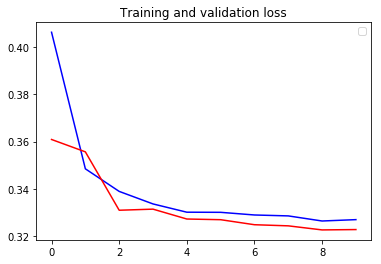

No handles with labels found to put in legend.


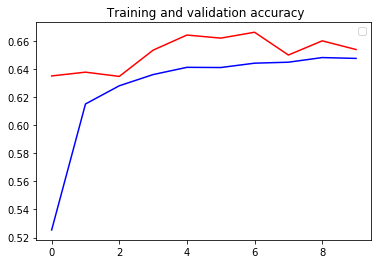

In [133]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.title(' Training and validation accuracy')
plt.legend()
plt.show()

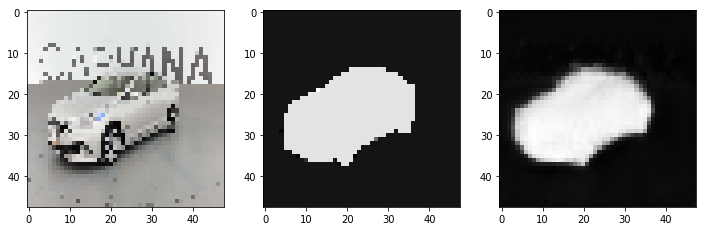

In [134]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
n_rand=random.randint(0,len(y_val)-1)
ax[0].imshow(x_val[n_rand,:,:,:])
ax[1].imshow(y_val[n_rand,:,:,0],'gray')
ax[2].imshow(y_hat[n_rand,:,:,0],'gray')